In [4]:
import json
from pprint import pprint
import pandas as pd
import numpy as np
import re as re
import sys
import csv
import time
import nltk
from nltk.stem.porter import *
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import scipy
import seaborn 
%matplotlib inline

## (1) Run the Twitter Streamer With Words .ipynb file
## (2) The file will collect tweets and store them in a MongoDB collection
## (3) Pull the MongoDB collection into this project file.

# Now pull the tweets from the collection of stored tweets in MongoDB

In [6]:
import pymongo
from pymongo import MongoClient

#creates a new mongodb database
#creates a connection to the mongoDB on local host 
client = MongoClient()

#allow access to the MongoServer Scripting Database
#db = client.Scripting

#the following also works
#selects the database 
db = client['Hacking_Tweets']
#selected the collection to call
collection = db.New_Project
#list names in the collection
db.list_collection_names()

['New_Project',
 'Final_Projectv3',
 'Final_Project_Master',
 'Final_Projectv4',
 'Final_Project_Class_Example',
 'Final_Projectv2',
 'Final_Project']

## How many tweets have been collected so far?

In [129]:
#how many records are in Final_Projectv2?
db.New_Project.count()
#Final_Projectv2.create_index([('id', pymongo.ASCENDING)], unique = True)

34573

# Twitter Text Analysis
### Connect to MongoDB Collections and Pull Text 

In [94]:
#list names in the collection
db.list_collection_names()

['New_Project',
 'Final_Projectv3',
 'Final_Project_Master',
 'Final_Projectv4',
 'Final_Project_Class_Example',
 'Final_Projectv2',
 'Final_Project']

### Convert Mongo Collection into DataFrame

In [95]:
from pandas.io.json import json_normalize
#call Final_Projectv3 and pull in ALL tweets
collection = db.New_Project
#find all tweets in the the MongoDB collection and store the json in the variable twitter_analysis
twitter_analysis = collection.find({}, {'_id':0})
#convert the json to a dataframe by normalizing it
twitterdf = pd.io.json.json_normalize(twitter_analysis)

#print the length of the dataframe
len(twitterdf)

7818

### Create initial Dataframe for Rules application

In [96]:
#the follwoing dictionary keys are of value for the analysis 
#create a new dataframe with only the below keys
twitterdataframe = twitterdf[["user.screen_name", "user.name", "user.statuses_count","text", "created_at",
                              "user.created_at", "lang", 'user.description','user.favourites_count', 'user.followers_count',
                              'user.friends_count',  'user.profile_use_background_image']]
#the statuses_count includes tweets and retweets, higher numbers mean more tweets/retweets!

twitterdataframe.head(1)

,user.screen_name,user.name,user.statuses_count,text,created_at,user.created_at,lang,user.description,user.favourites_count,user.followers_count,user.friends_count,user.profile_use_background_image
0,JoseMadai,José Madai,4502,Essa expressão “pra baixo” do Léo não é nenhum...,Tue Apr 30 02:52:42 +0000 2019,Sat Jan 30 18:37:19 +0000 2016,pt,Too school and fool.,2428,76,280,True


## Create rules to identify bots and classify them (see references in the report)
#### Rule (1) Tweets per day > 50 is classified as a bot && Tweets per day <= 50 as a person
#### Rule (2) user.screen_names and user.name contain more than 4 numbers, binary value returned
#### Rule (3) if profile_use_background_image is False AND user.favourites_count > 2000 OR user.description == None 
#### Rule (4) if profile_use_background_image is True AND user.friends_count > 2000 OR user.descrption == None 
#### Rule (5) If Rule(1) or Rule(2) or Rule (3) or Rule(4) are == 1 (True) then Is a bot elst ==0 

##### Rule 1

In [97]:
import datetime
from datetime import datetime, timedelta, date, time
from email.utils import parsedate_tz
 

#create function to convert twitter date to datetime 
def to_datestime(datestring):
    '''Fuction to take in a twitter date string, then convert it to a datetime, however when inputing into a
    into a pandas dataframe it converts the datetime into a timestamp'''
    time_tuple = parsedate_tz(datestring.strip())
    dt = datetime(*time_tuple[:6])
    return dt - timedelta(seconds=time_tuple[-1])

#create a new column that converts the user.created_at string date to a datetime. 
twitterdataframe['user_created'] = twitterdataframe['user.created_at'].map(to_datestime)

#enter todays current date below!!!!!! or the date the tweets were collected!!!!
my_date = datetime(2019, 4, 29, 0, 0, 0)

date2 = datetime.combine(my_date, time.min)
#function to subtract datetime from datetime to return the number of days
def differ_days(date1, date2):
    '''The function will take two datetime objects and subtract them, then return the number of days between.'''
    a = date1
    b = date2
    return (a-b).days

#take the user_created 
pydate = pd.to_datetime(twitterdataframe['user_created'])

#iterate through all the items in the dataframe 
pydatetime = pydate.iteritems()

#convert the python datetime to a list, then covert it to a dictionary
pydatetime = dict(list(pydatetime))

#create a list of values to use for counting 
value = [num for num in range(0,len(twitterdataframe['user_created']))]

#create a list of the values to use for counting
pydate_list = [pd.Timestamp.to_pydatetime(pydate.iloc[key]) for key in value]

#create new column in dataframe with the number of days since the account has been created
twitterdataframe['user_created_days'] = [differ_days(date2, pydate_list[num]) for num, value in enumerate(pydate_list)]

#with the user days created, take the 'users.statuses_count' column and divide by the 'user_created_days' number
#this will return tweets_per_day
twitterdataframe['tweets_per_day'] = [twitterdataframe['user.statuses_count'].iloc[num] / twitterdataframe['user_created_days'].iloc[num] for num, value in enumerate(pydate_list)]

# take the tweets from tweets per day, coverts to a list, then passes through the for loop.
tpd = twitterdataframe['tweets_per_day'].tolist()

#takes the list tpd (tweets per day), enumerates the list for the key, and stores the key value in the variable value
value = [num for num, value in enumerate(tpd)]
#empty list created
rule_1 = []
#for the number in value, pass the number into the if statement below.
for num in value:
    #if the list number is greater than or equal to 50, array value is given 1
    if tpd[num] >= 50:
        array = 1
            #return array
    #else if the list number is less than 50, array value is given 0
    elif tpd[num] < 50:
        array = 0
    #store all the values for the for loop in the rule_1 list
    rule_1.append(array)
    
#create a new column in the dataframe with the new binaries    
twitterdataframe['rule1'] = rule_1 

C:\Users\Maximilliano\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Maximilliano\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Maximilliano\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in longlong_scalars
C:\Users\Maximilliano\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be s

In [83]:
twitterdataframe.head(2)

,user.screen_name,user.name,user.statuses_count,text,created_at,user.created_at,lang,user.description,user.favourites_count,user.followers_count,user.friends_count,user.profile_use_background_image,user_created,user_created_days,tweets_per_day,rule1
0,JoseMadai,José Madai,4502,Essa expressão “pra baixo” do Léo não é nenhum...,Tue Apr 30 02:52:42 +0000 2019,Sat Jan 30 18:37:19 +0000 2016,pt,Too school and fool.,2428,76,280,True,2016-01-30 18:37:19,1184,3.802365,0
1,apushAlive,apushAlive,7653,"crissyAssistTryingToGetMeToTalkShitToHer""this ...",Tue Apr 30 02:52:48 +0000 2019,Sat Dec 05 15:49:44 +0000 2015,en,i just found out i was trapped or hacked by so...,0,8,53,True,2015-12-05 15:49:44,1240,6.171774,0


##### Rule 2

In [98]:
#Rule 2 screen.names contains more than 4 numbers
import re

# Function to extract all the numbers from the given string 
def getNumbers(str): 
    '''Function to grab each number from a string, if >= 4 then returns (1)true, of not, returns (0)false'''
    #find all numbers in the string
    array = re.findall(r'[+-]?\d+(?:\.\d+)?', str) 
    #create a list of all the numbers seperated by each number
    array = [list(num) for x in array for num in x]
    #return True if the length of all numbers in the list is 4 or greater or False if less.
    return 1 if len(array) >= 4 else 0
###############################
# Test block for the getNumbers function 
#word = "robert23467 block"
#test = getNumbers(word) 
#print(test) 
###############################

#create a new column that converts the user.created_at string date to a datetime. 
twitterdataframe['rule2a']= twitterdataframe['user.screen_name'].map(getNumbers)
#create a new column that classifies the user.name if 4 or more letters
twitterdataframe['rule2b'] = twitterdataframe['user.name'].map(getNumbers)

C:\Users\Maximilliano\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Maximilliano\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


##### Rule 3

In [99]:
#Rule (3) if profile_use_background_image is False AND user.favourites_count > 2000 OR user.description == None 
background = twitterdataframe['user.profile_use_background_image'].tolist()
value = [num for num, value in enumerate(background)]

fav_count = list(twitterdataframe['user.favourites_count'])
user_descrip = twitterdataframe['user.description'].tolist()

def botrule3(col1, col2, col3, number):
    if col1[number] == False and col2[number] > 2000 or col1[number] == False and col3[number] == None:
        return 1
    else:
        return 0

twitterdataframe['rule3'] = [botrule3(background, fav_count,user_descrip, test) for test in value]



C:\Users\Maximilliano\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


##### Rule 4

In [100]:
#Rule (4) if profile_use_background_image is True AND user.friends_count > 2000 OR user.descrption == None
value = [num for num, value in enumerate(background)]
background = twitterdataframe['user.profile_use_background_image'].tolist()
friend_count = list(twitterdataframe['user.friends_count'])
user_descrip = twitterdataframe['user.description'].tolist()

def botrule4(col1, col2, col3, number):
    if col1[number] == True and col2[number] > 2000 or col1[number] == True and col3[number] == None:
        return 1
    else:
        return 0

twitterdataframe['rule4'] = [botrule4(background, friend_count,user_descrip, test) for test in value]



C:\Users\Maximilliano\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


##### Rule 5

In [101]:
#Takes all the rules, and if any of the rules is == 1 then it returns a 1 and classifed as a bot!!
is_bot = []
#value = [num for num, value in enumerate(background)]
for num in range(0, len(twitterdataframe['rule1'])):
    if twitterdataframe['rule1'][num] == 1 or \
    twitterdataframe['rule2a'][num] == 1 or  \
    twitterdataframe['rule2b'][num] == 1 or \
    twitterdataframe['rule3'][num] == 1 or \
    twitterdataframe['rule4'][num] == 1:
        array = 1
    else:
        array = 0
    is_bot.append(array)
    
twitterdataframe['is_a_bot'] = is_bot
    

C:\Users\Maximilliano\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


##### Create new dataframe for storing in Mongo

In [102]:
twitterdataframe.rename(columns={"user.screen_name":"screen_name", "user.name":"name", "user.statuses_count":"status_count","text":'text', "created_at":'created_at',
                              "user.created_at":"user_created_at", "lang":'language', 'user.description':'description','user.favourites_count':'favorites_count', 'user.followers_count':'followers_count',
                              'user.friends_count':'friends_count', 'user_created_days':'user_created_days', 
                              'tweets_per_day':'tweets_per_day', 'is_a_bot':'is_a_bot'}, inplace=True)
#tw_df = 

twitterdataframe.head(1)

,screen_name,name,status_count,text,created_at,user_created_at,language,description,favorites_count,followers_count,...,user.profile_use_background_image,user_created,user_created_days,tweets_per_day,rule1,rule2a,rule2b,rule3,rule4,is_a_bot
0,JoseMadai,José Madai,4502,Essa expressão “pra baixo” do Léo não é nenhum...,Tue Apr 30 02:52:42 +0000 2019,Sat Jan 30 18:37:19 +0000 2016,pt,Too school and fool.,2428,76,...,True,2016-01-30 18:37:19,1184,3.802365,0,0,0,0,0,0


In [103]:
#convert the text to a list out of a series
twitter_text = twitterdataframe['text'].tolist()


### Translate Tweet Text, Username, and Description

In [104]:
# The following code for tranlation was borrowed from: https://github.com/mouuff/mtranslate/blob/master/mtranslate/core.py

import sys
import re

if (sys.version_info[0] < 3):
    #pythong 2 syntax
    import urllib2
    import urllib
    import HTMLParser
else:
    #python 3 syntax
    import html.parser
    import urllib.request
    import urllib.parse

#this is the user agent string google will see as it is interpreting the tweets    
agent = {'User-Agent':
"Mozilla/4.0 (\
compatible;\
MSIE 6.0;\
Windows NT 5.1;\
SV1;\
.NET CLR 1.1.4322;\
.NET CLR 2.0.50727;\
.NET CLR 3.0.04506.30\
)"}

#these functions are designed to identify if python 2 or python 3 is being used. 
def unescape(text):
    if (sys.version_info[0] < 3):
        parser = HTMLParser.HTMLParser() #python 2
    else:
        parser = html.parser.HTMLParser() #python 3
    return (parser.unescape(text))

def translate(to_translate, to_language="auto", from_language="auto"):
    """Returns the translation using google translate
    you must shortcut the language you define
    (French = fr, English = en, Spanish = es, etc...)
    if not defined it will detect it or use english by default
    Example:
    print(translate("salut tu vas bien?", "en"))
    hello you alright?
    """
    base_link = "http://translate.google.com/m?hl=%s&sl=%s&q=%s"
    if (sys.version_info[0] < 3):
        to_translate = urllib.quote_plus(to_translate)
        link = base_link % (to_language, from_language, to_translate)
        request = urllib2.Request(link, headers=agent)
        raw_data = urllib2.urlopen(request).read()
    else:
        to_translate = urllib.parse.quote(to_translate)
        link = base_link % (to_language, from_language, to_translate)
        request = urllib.request.Request(link, headers=agent)
        raw_data = urllib.request.urlopen(request).read()
    data = raw_data.decode("utf-8")
    expr = r'class="t0">(.*?)<'
    re_result = re.findall(expr, data)
    if (len(re_result) == 0):
        result = ""
    else:
        result = unescape(re_result[0])
    return (result)

In [105]:
################ This takes a loooooong time as projectv3 contains over 14000 tweets ##################

#Translate tweet text for Final_Project_Master dataframe (tw_df)
new_tweets = [translate(x) for x in twitter_text]

### Prepare twitter text for analysis.

In [106]:
#add a new column with the new_tweets to the dataframe
twitterdataframe["translated_text"] = new_tweets

#selected the collection to call
collection = db.New_Project_Translated

twitterdataframe.head(5)

#store the new new translated tweets into a new mongo collection.
#if twitter_search doesn't exist, it will be created.
twitter_data = twitterdataframe.to_dict('records')

######!!!! ONLY RUN THE BELOW COMMAND IF YOU WANT TO STORE A NEW COLLECTION !!!!###############
#db.New_Project_Translated.insert_many(twitter_data)

C:\Users\Maximilliano\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [107]:
#seperate the bot tweets and not bot tweets
#bot tweets
real_tw_df = twitterdataframe[twitterdataframe['is_a_bot'] == 0]
bot_tw_df = twitterdataframe[twitterdataframe['is_a_bot'] == 1]

print(len(real_tw_df), len(bot_tw_df))
# tweets seperated result in more bots than real accounts in reference to hacking information

3222 4596


In [108]:
import pandas as pd
twitterdataframe.to_csv('tweet_df.csv', sep=',', encoding='utf-8')
# Need to clean the tweets of erronious data such as tweets about Julian Assange, with the word News, 

#  Now that all tweet text is loaded, perform the following:

## (1) Use the tweet tokenizer from NLTK and process for the most frequent words in the tweets
## (1b) Create a word cloud and graph with word distribution from new_tweets

## (2) Use VADER sentiment analysis to identify if hacking tweets are positive or negative

## (2b) Add another column to tw_df with the sentiment score

## (3) Compare the sentiment analysis with the rule methodology across all collection of tweets  

## (4) Use sklearn to develop a predition model based on true or false tweet classification.

##### below is for future analysis
 
## (5) Collect new tweets, store in a new mongoDB collection, and then apply predition model to tweets to see if they are true hacking tweets or not.

## (6) Take the tweets and plot the network via NetworkX and identify if node centers have commonality with model prediction

### Tokenize Tweets with NLTK tweet tokenizer

In [109]:
#use tweet tokenizer to tokenize the tweets in the mongoDB collection

ttokenizer = nltk.tokenize.TweetTokenizer()
#tweets are tokenized into tokens varriable
tokens = [ttokenizer.tokenize(tweet_text) for tweet_text in new_tweets]

print(len(tokens), tokens[10])

7818 ['crissyTryingToGetMeToTalkShitToHer', '"', 'god', 'fucking', 'damn', 'it', '"', '#170', '#chris', '#cris', '#criss', '#chrissy', '#crissy', '#tina', '#crystal', '…', 'https://t.co/hpxkGV0t0E']


In [110]:
#need all tweets to be lowercase
lower_tweet_tokens =[tok.lower() for tweet in new_tweets for tok in ttokenizer.tokenize(tweet)]

#tok.lower() for tweet in tweetlist for tok in ttokenizer.tokenize(tweet)
print(type(lower_tweet_tokens), len(lower_tweet_tokens))

#tokens[45]

<class 'list'> 163632


In [47]:
#next, need to remove stop words from the list
nltk_stopwords = nltk.corpus.stopwords.words('english')
len(nltk_stopwords)

183

In [111]:
#removes stop words from the list
stopped_tokens = [tok for tok in lower_tweet_tokens if not tok in nltk_stopwords]
stopped_tokens[:50]

['expression',
 '"',
 '"',
 'leo',
 'nothing',
 'new',
 '.',
 'always',
 'looked',
 'like',
 'could',
 'things',
 '...',
 'https://t.co/2znws3ndlb',
 'crissyassisttryingtogetmetotalkshittoher',
 '"',
 'lost',
 'respect',
 'crissy',
 ',',
 '#chris',
 '#cris',
 '#criss',
 '#chrissy',
 '…',
 'https://t.co/bjm7jkeyul',
 '@jenhansen31',
 ':',
 'russia',
 'skipping',
 'hacking',
 'moving',
 'straight',
 'owning',
 'companies',
 'oversee',
 'elections',
 '.',
 'maryland',
 'elections',
 '…',
 '@theregister',
 ':',
 "america's",
 'anti-hacking',
 'laws',
 'loose',
 ',',
 'even',
 'donald']

In [112]:
# function that takes a word and returns true if it consists only
#   of non-alphabetic characters
def alpha_filter(w):
    # pattern to match a word of non-alphabetical characters
    pattern = re.compile('^[^a-z]+$')
    if (pattern.match(w)):
        return True
    else:
        return False

# remove words with all non-alphabetic characters
tweet_token_list = [tok for tok in stopped_tokens if not alpha_filter(tok)]

In [50]:
msgFD = nltk.FreqDist(tweet_token_list)
top_words = msgFD.most_common(30)
for word, freq in top_words:
    print(word, freq)
    
#as seen, there are some words that are not needed, ie assange, julian, https:.//.

elections 159
hacking 152
russia 80
straight 71
@jenhansen31 70
skipping 70
moving 70
owning 70
companies 70
oversee 70
maryland 70
new 54
deserve 32
news 31
voting 27
russians 26
know 25
hacked 24
machines 24
important 21
election 20
normal 18
would 17
counted 17
bill 17
novelty 16
@ananavarro 16
floridians 16
answers 16
americans 16


In [113]:
# Libraries
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def word_cloud(wd_list):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=21,
        colormap='jet',
        max_words=50,
        max_font_size=200).generate(all_words)

    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="gaussian");

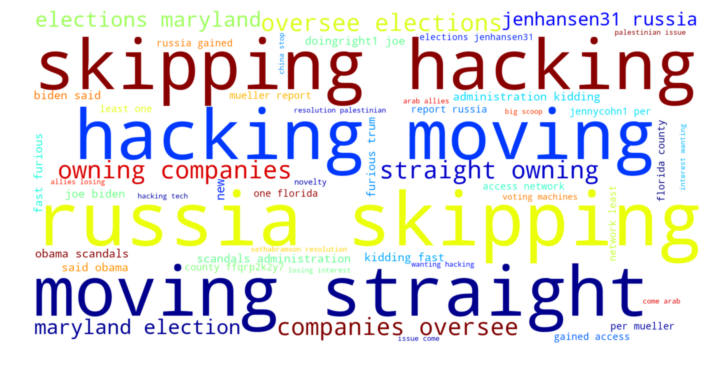

In [114]:
#creates word cloud
word_cloud(tweet_token_list)

### VADER Sentiment Analysis

In [115]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [116]:
vader_scores = [analyzer.polarity_scores(tweets) for tweets in new_tweets]

In [117]:
for sentence, score_dict in zip(new_tweets, vader_scores):
    score_dict['text'] = sentence

In [118]:
vader_df = pd.DataFrame(vader_scores)[['compound', 'neg', 'neu', 'pos']]
#vader_df = vader_df.sort_values('compound', ascending=False)
vader_df

,compound,neg,neu,pos
0,0.3612,0.000,0.872,0.128
1,0.2023,0.140,0.671,0.189
2,0.2263,0.000,0.909,0.091
3,-0.6995,0.225,0.775,0.000
4,-0.4946,0.141,0.807,0.052
5,0.4310,0.000,0.870,0.130
6,0.0000,0.000,1.000,0.000
7,0.5927,0.000,0.851,0.149
8,-0.2057,0.185,0.815,0.000
9,0.2263,0.000,0.909,0.091


### Add the VADER scores to the tw_df dataframe

In [119]:
master_df = pd.concat([twitterdataframe,vader_df], axis=1)
master_df[['neg','neu','pos']].describe()


,neg,neu,pos
count,7818.000000,7818.000000,7818.000000
mean,0.069308,0.849667,0.079747
std,0.122578,0.152446,0.106200
min,0.000000,0.000000,0.000000
25%,0.000000,0.760000,0.000000
50%,0.000000,0.901000,0.070000
75%,0.111000,1.000000,0.112000
max,1.000000,1.000000,1.000000


In [120]:
master_df.shape

(7818, 26)

In [121]:
master_df.head(1)

,screen_name,name,status_count,text,created_at,user_created_at,language,description,favorites_count,followers_count,...,rule2a,rule2b,rule3,rule4,is_a_bot,translated_text,compound,neg,neu,pos
0,JoseMadai,José Madai,4502,Essa expressão “pra baixo” do Léo não é nenhum...,Tue Apr 30 02:52:42 +0000 2019,Sat Jan 30 18:37:19 +0000 2016,pt,Too school and fool.,2428,76,...,0,0,0,0,0,"This expression ""down"" from Leo is nothing new...",0.3612,0.0,0.872,0.128


In [ ]:
master_df.to_csv('master_df.csv', sep=',', encoding='utf-8')

In [122]:
# After joining the two dataframes, seperate the bots and real based on rules...
master_real_tw_df = master_df[master_df['is_a_bot'] == 0]
master_bot_tw_df = master_df[master_df['is_a_bot'] == 1]

In [123]:
# Now that the tweets are seperated, generate desciptive stats on each and compare
master_real_tw_df[['neg','neu','pos']].describe()

,neg,neu,pos
count,3222.000000,3222.000000,3222.000000
mean,0.063762,0.855268,0.079734
std,0.122504,0.157201,0.114479
min,0.000000,0.000000,0.000000
25%,0.000000,0.773000,0.000000
50%,0.000000,0.909000,0.049000
75%,0.098000,1.000000,0.108750
max,1.000000,1.000000,1.000000


In [124]:
master_bot_tw_df[['neg','neu','pos']].describe()

,neg,neu,pos
count,4596.000000,4596.000000,4596.000000
mean,0.073196,0.845741,0.079756
std,0.122493,0.148913,0.100001
min,0.000000,0.000000,0.000000
25%,0.000000,0.752000,0.000000
50%,0.000000,0.896500,0.070000
75%,0.125250,1.000000,0.113000
max,1.000000,1.000000,1.000000


### Is there commonality between Sentiment Analysis and a Bot?

In [ ]:
master_df = pd.read_csv('master_df.csv')

In [125]:
#create new dataframe with selected features
filtered_features = ['status_count','user_created', 'favorites_count', 'friends_count','screen_name', 'name', 'text','rule1','rule2a','rule2b','rule3','rule4', 'created_at', 'user_created_at', 'language', 'description','translated_text']
model_df = master_df.drop(filtered_features,1)
model_df = model_df.replace(np.inf, 0)
model_df.to_csv('model_df.csv', sep=',', encoding='utf-8')
model_df.head(10)


,followers_count,user.profile_use_background_image,user_created_days,tweets_per_day,is_a_bot,compound,neg,neu,pos
0,76,True,1184,3.802365,0,0.3612,0.000,0.872,0.128
1,8,True,1240,6.171774,0,0.2023,0.140,0.671,0.189
2,614,False,2177,35.711070,1,0.2263,0.000,0.909,0.091
3,707,True,4448,79.403777,1,-0.6995,0.225,0.775,0.000
4,28049,False,3800,19.522632,1,-0.4946,0.141,0.807,0.052
5,8,True,1240,6.172581,0,0.4310,0.000,0.870,0.130
6,325,True,1155,3.529004,0,0.0000,0.000,1.000,0.000
7,2105,True,1949,1.136480,0,0.5927,0.000,0.851,0.149
8,615,True,3660,10.704918,1,-0.2057,0.185,0.815,0.000
9,5386,True,2249,44.922188,1,0.2263,0.000,0.909,0.091


In [ ]:
# After multiple attempts to run the analysis, the classifier machine learning models are taking to long. 
# Will take samples randomly and compare from the dataset. 
model_df = model_df.sample(2000, replace = True)

In [126]:
# Load libraries
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
# Import train_test_split function
from sklearn.model_selection import train_test_split
import numpy as np
# Will use data model_df from above.  Need to remove the is_a_bot 

y = model_df[['is_a_bot']]
#y = y.reset_index()


filter_col = ['is_a_bot']
X = model_df.drop(filter_col, 1)

X = X.replace(np.inf, 0)
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test


In [127]:

# Import Support Vector Classifier
from sklearn.svm import SVC

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

svc=SVC(probability=True, kernel='linear')

# Create adaboost classifer object
abc =AdaBoostClassifier(n_estimators=50, base_estimator=svc,learning_rate=1)

# Train Adaboost Classifer
model = abc.fit(X_train, y_train.values.ravel())

#Predict the response for test dataset
y_pred = model.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.6035805626598465
Precision: 0.6016949152542372
Recall: 0.9733044733044733


In [128]:
from sklearn import metrics
def measure_performance(X,y,model, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred=model.predict(X)   
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)),"\n")

    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y,y_pred),"\n")
        
    if show_confusion_matrix:
        print ("Confusion matrix")
        print (metrics.confusion_matrix(y,y_pred),"\n")
        
measure_performance(X_train,y_train,model, show_classification_report=True, show_confusion_matrix=True)

Accuracy:0.602 

Classification report
              precision    recall  f1-score   support

           0       0.69      0.07      0.13      2262
           1       0.60      0.98      0.74      3210

   micro avg       0.60      0.60      0.60      5472
   macro avg       0.64      0.52      0.43      5472
weighted avg       0.64      0.60      0.49      5472
 

Confusion matrix
[[ 157 2105]
 [  71 3139]] 

